<a href="https://colab.research.google.com/github/mohadi21/Projet-de-Big-Data-avec-Apache-Spark/blob/main/BigDataProjet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Master 2 AMSD

Mohamed BOUDJEMAI



# Mise en place de l’environnement de travail

In [ ]:
# Run below commands in google colab
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark3.0.0
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
# unzip it
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
# install findspark 
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init("/content/spark-3.0.2-bin-hadoop2.7")


In [ ]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages org.apache.spark:spark-avro_2.12:3.0.2 pyspark-shell"

In [ ]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("mon application").setMaster("local[4]")
sc = SparkContext(conf=conf)

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config(conf=conf).getOrCreate()


# Données

In [ ]:
!wget -q : http://qwone.com/~jason/20Newsgroups/20news-19997.tar.gz
!tar xf 20news-19997.tar.gz


chargement des document alt.atheism et rec.sport.baseball dans 2 RDD 



In [ ]:
rdd1 = sc.wholeTextFiles("/content/20_newsgroups/alt.atheism")
rdd2 = sc.wholeTextFiles("/content/20_newsgroups/rec.sport.baseball")

suppresion du chemin dans les RDD, on garde que le contenu des documents

In [ ]:
rdd1 = rdd1.map(lambda x: x[1])
rdd2 = rdd2.map(lambda x: x[1])

In [ ]:
rdd1.first()


"From: Alan.Olsen@p17.f40.n105.z1.fidonet.org (Alan Olsen)\nSender: postmaster@therose.pdx.com\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!psgrain!qiclab!therose!postmaster\nNewsgroups: alt.atheism\nSubject: Albert Sabin\nMessage-ID: <735424748.AA00436@therose.pdx.com>\nDate: Wed, 21 Apr 1993 03:15:18 -0800\nLines: 41\n\n\nBR> From: wpr@atlanta.dg.com (Bill Rawlins)\nBR> Newsgroups: alt.atheism\nBR> Organization: DGSID, Atlanta, GA\n\nBR>         The problem is that most scientists exclude the\nBR> possibility of the         supernatural in the question of\nBR> origins.  Is this is a fair premise?         I utterly\nBR> reject the hypothesis that science is the highest form of   \nBR>      truth.\n\nIt is better than the crap that the creationists put out.  So far all they\nhave been able to manage is distortions and half-truths. (When they are not\ntaking quotes out

In [ ]:
rdd2.first()

'Newsgroups: rec.sport.baseball\nPath: cantaloupe.srv.cs.cmu.edu!rochester!udel!news.udel.edu!darwin.sura.net!haven.umd.edu!uunet!island!fester\nFrom: fester@island.COM (Mike Fester)\nSubject: Re: Bonilla\nMessage-ID: <1993Apr23.200913.6611@island.COM>\nSender: usenet@island.COM (The Usenet mail target)\nOrganization: /usr/local/rn/organization\nReferences: <13615@news.duke.edu> <1993Apr21.012139.13444@Princeton.EDU>\nDate: Fri, 23 Apr 1993 20:09:13 GMT\nLines: 25\n\nIn article <1993Apr21.012139.13444@Princeton.EDU> roger@astro.princeton.edu (Roger Lustig) writes:\n\n>When I say "black," I mean US-born black people for the purposes of this\n>discussion.  Hispanic players were in baseball before 1947, and one \n>team in the 50\'s signed lots of hispanics because they went over better\n>with the local audience than blacks did.  \n\nWhat about black hispanics?\n\n>>And why would more hispanics stick around than blacks?\n>\n>Don\'t know.  But remember: this is the country that had special 

création de la fontion extractChamp pour extraire des different champs de l'entete

In [ ]:
def extractChamp(data, category):
    entete = data[0]
    corps = data[1]
    infoEntete = dict()

    newGroup = 'Newsgroups: '
    findNewGroup = entete.find(newGroup)
    endNewGroup = entete[findNewGroup:-1].find('\n')
    infoEntete['newsGroups'] = entete[(findNewGroup + len(newGroup)):(findNewGroup + endNewGroup)].strip()

    lines = 'Lines: '
    findLines = entete.find(lines)
    infoEntete['lines'] = entete[(findLines + len(lines)):-1].strip()

    organization = 'Organization: '
    findOrganization = entete.find(organization)
    endOrganization = entete[findOrganization:-1].find('\n')
    infoEntete['organization'] = entete[(findOrganization + len(organization)):(findOrganization + endOrganization)].strip()

    subject = 'Subject: '
    findSubject = entete.find(subject)
    endSubject = entete[findSubject:-1].find('\n')
    infoEntete['subject'] = entete[(findSubject + len(subject)):(findSubject + endSubject)].strip()

    date = 'Date: '
    findDate = entete.find(date)
    endDate = entete[findDate:-1].find('\n')
    infoEntete['date'] = entete[(findDate + len(date)):(findDate + endDate)].strip()

    infoEntete['category'] = category

    return (infoEntete, corps)

création des fonction findSeparator et splitHeadBody pour séparer l'entete du corps

In [ ]:
import re

def findSeparator(elem):
    findSeparator = re.search('Lines: [0-9]+\n+',elem)
    if (findSeparator):
        return findSeparator.end()
    else:
        findSeparator = re.search('GMT\n', elem)
    return findSeparator.end()

def splitHeadBody(elem):
    separator = findSeparator(elem)
    return (elem[0:separator].strip(), elem[separator:-1].strip())


In [ ]:
altheismSplit = rdd1.map(splitHeadBody)
baseballSplit = rdd2.map(splitHeadBody)
altheism = altheismSeparate.map(lambda x: extractChamp(x,'altheism'))
baseball = baseballSeparate.map(lambda x: extractChamp(x,'baseball'))

In [ ]:
RDD = altheism.union(baseball)

model des RDD

In [ ]:
RDD.take(2)

[({'category': 'altheism',
   'date': 'Wed, 21 Apr 1993 03:15:18 -0800',
   'lines': '4',
   'newsGroups': 'alt.atheism',
   'organization': 'sen@p17.f40.n105.z1.fidonet.org (Alan Olsen)\nSender: postmaster@therose.pdx.com\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!psgrain!qiclab!therose!postmaster\nNewsgroups: alt.atheism\nSubject: Albert Sabin\nMessage-ID: <735424748.AA00436@therose.pdx.com>\nDate: Wed, 21 Apr 1993 03:15:18 -0800\nLines:',
   'subject': 'Albert Sabin'},
  "BR> From: wpr@atlanta.dg.com (Bill Rawlins)\nBR> Newsgroups: alt.atheism\nBR> Organization: DGSID, Atlanta, GA\n\nBR>         The problem is that most scientists exclude the\nBR> possibility of the         supernatural in the question of\nBR> origins.  Is this is a fair premise?         I utterly\nBR> reject the hypothesis that science is the highest form of   \nBR>      truth.\n\nIt is better t

on transforme chaque ligne du RDD en Row pour pouvoir retrouver chaque champs quand on va transformer le RDD en Dataframe.

In [ ]:
from pyspark.sql import Row
rowRDD = RDD.map(lambda x : Row(x[0]['newsGroups'],x[0]['lines'],x[0]['organization'],x[0]['subject'],x[0]['date'],x[0]['category'],x[1]))

création de la structure du dataframe

In [ ]:
from pyspark.sql.types import *
schema = StructType([
StructField("newsGroups", StringType(), True),
StructField("lines", StringType(), True),
StructField("organization", StringType(), True),
StructField("subject", StringType(), True),
StructField("date", StringType(), True),
StructField("category", StringType(), True),
StructField("content", StringType(), True)])

création du dataframe avec la structure crée

In [ ]:
dfWithoutSchema = spark.createDataFrame(rowRDD,schema)

In [ ]:
dfWithoutSchema.show()

+--------------------+-----+--------------------+--------------------+--------------------+--------+--------------------+
|          newsGroups|lines|        organization|             subject|                date|category|             content|
+--------------------+-----+--------------------+--------------------+--------------------+--------+--------------------+
|         alt.atheism|    4|sen@p17.f40.n105....|        Albert Sabin|Wed, 21 Apr 1993 ...|altheism|BR> From: wpr@atl...|
|alt.atheism,soc.c...|    3|upe.srv.cs.cmu.ed...|Re: The nonexista...|16 Apr 93 21:25:2...|altheism|>In article <kutl...|
|         alt.atheism|    2|upe.srv.cs.cmu.ed...|Re: A Little Too ...|23 Apr 93 02:43:0...|altheism|Jon Livesey write...|
|alt.atheism,talk....|    2|Sponsored account...|Re: The Universe ...|Tue, 20 Apr 1993 ...|altheism|Message-ID: <Efp2...|
|         alt.atheism|    7|                  NH|Re: Yet more Rush...|Thu, 15 Apr 1993 ...|altheism|In article <1993A...|
|alt.atheism,talk....|  

sauvegarde du dataframe au format parquet

In [ ]:
dfWithoutSchema.write.parquet("output/data.parquet")

sauvegarde du dataframe au format avro

In [ ]:
dfWithoutSchema.write.format("avro").save("output/data.avro")

# Analyse descriptive

In [ ]:
dfWithoutSchema.printSchema()

root
 |-- newsGroups: string (nullable = true)
 |-- lines: string (nullable = true)
 |-- organization: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: string (nullable = true)



In [ ]:
df = dfWithoutSchema

In [ ]:
df.select('category').distinct().count()

2

on retrouve bien 2 catégorie differente dans notre dataframe

In [ ]:
df.select('organization').distinct().count()

578

on peut voir qu'il y a 578 organisation différentes

In [ ]:
from pyspark.sql.functions import col, countDistinct

df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()

+----------+-----+------------+-------+----+--------+-------+
|newsGroups|lines|organization|subject|date|category|content|
+----------+-----+------------+-------+----+--------+-------+
|        36|   43|         578|    762|1994|       2|   1994|
+----------+-----+------------+-------+----+--------+-------+



on a utiliser un countDistinct sur toute les colones pour avoir le nombre de champs différent dans toute les colones.

In [ ]:
import matplotlib.pyplot as plt

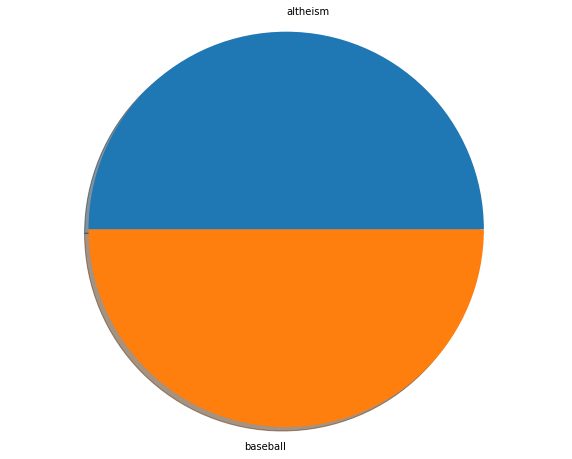

In [ ]:
category = df.cube("category").count()
category= category.na.drop()
category.select('category').distinct().count()

labels = category.select('category')
labels = labels.toPandas()
labels = labels.to_numpy()
labels = labels.reshape(len(labels))
sizes =  category.select('count')
sizes = sizes.toPandas()
sizes = sizes.to_numpy()
sizes = sizes.reshape(len(sizes))

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, labels=labels, shadow=True)

plt.axis('equal')
plt.show()

In [ ]:
newsgroup = df.cube("newsGroups").count()
newsgroup= newsgroup.na.drop()
newsgroup.select('newsGroups').distinct().count()

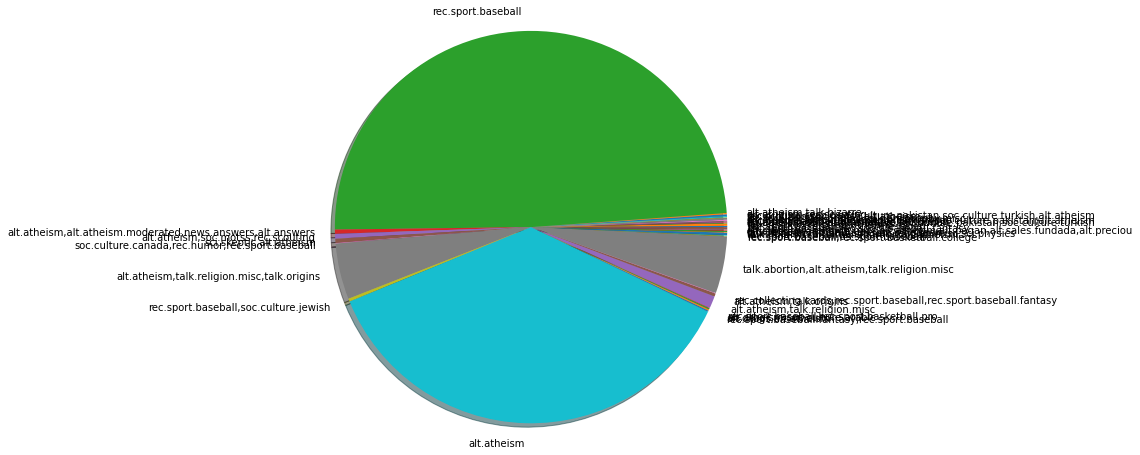

In [ ]:

# Data to plot
labels = newsgroup.select('newsGroups')
labels = labels.toPandas()
labels = labels.to_numpy()
labels = labels.reshape(len(labels))
sizes =  newsgroup.select('count')
sizes = sizes.toPandas()
sizes = sizes.to_numpy()
sizes = sizes.reshape(len(sizes))

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, labels=labels, shadow=True)

plt.axis('equal')
plt.show()

# Transformation du texte et clustering

on tokenize le contenu des mails et on crée une représentation vectoriel des mots dans features

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
tokenizer = Tokenizer(inputCol="content", outputCol="words")
wordsData = tokenizer.transform(df)
hashingTF = HashingTF(inputCol="words", outputCol="features", numFeatures=20)
featurizedData = hashingTF.transform(wordsData)

In [ ]:
featurizedData.show()

+--------------------+-----+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+
|          newsGroups|lines|        organization|             subject|                date|category|             content|               words|            features|
+--------------------+-----+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+
|         alt.atheism|    4|sen@p17.f40.n105....|        Albert Sabin|Wed, 21 Apr 1993 ...|altheism|BR> From: wpr@atl...|[br>, from:, wpr@...|(20,[0,1,2,3,4,5,...|
|alt.atheism,soc.c...|    3|upe.srv.cs.cmu.ed...|Re: The nonexista...|16 Apr 93 21:25:2...|altheism|>In article <kutl...|[>in, article, <k...|(20,[0,1,2,3,4,5,...|
|         alt.atheism|    2|upe.srv.cs.cmu.ed...|Re: A Little Too ...|23 Apr 93 02:43:0...|altheism|Jon Livesey write...|[jon, livesey, wr...|(20,[0,1,2,3,4,5,...|
|alt.atheism,tal

on fait un kmeans sur le contenu des mails

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(featurizedData)

# Make predictions
predictions = model.transform(featurizedData)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.9949627289244067
Cluster Centers: 
[16.75889724 11.33784461  8.25914787 18.84511278 12.39849624 12.44912281
 12.43107769 12.78345865 16.29974937 16.05062657  9.72431078 12.76842105
 63.15137845 11.82807018  8.25714286 16.31578947 13.55588972 19.07218045
  9.34085213 11.23759398]
[ 149.4  135.    95.4  165.8  111.4  133.6  128.6  136.4  178.8  146.
   94.   132.4 3031.2  114.4   86.8  187.   106.4  225.4   94.   106.2]


In [ ]:
predictions.select("prediction").distinct().count()

2

In [ ]:
predict = predictions.select("prediction")
predict = predict.toPandas()
predict = predict.to_numpy()
predict

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [ ]:
import pandas as pd
from pyspark.sql.functions import when
basePartition = dfWithoutSchema.select('category')
basePartition = basePartition.withColumn("category", when(col("category") == "altheism","0")
                                 .otherwise("1"))
basePartition = basePartition.toPandas()
basePartition= basePartition.to_numpy()

In [ ]:
predict = predict.reshape(2000)
basePartition = basePartition.reshape(2000)

In [ ]:
import numpy as np
np.unique(prediction)

array([0, 1], dtype=int32)

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(predict, basePartition)

0.00014202781911687058

la qualité du kmeans est mauvais comme le NMI est tres faible et proche de 0. on ne retrouve pas les deux catégory a partir du contenu des mails.

# Implémentation de K-means unidimensionnel


In [ ]:
def compute_centroids(rdd1,rdd2):
  sum_by_cluster_id = 
  count_by_cluster_id = 
def assign_clusters(rdd1,rdd2):


In [ ]:
!pip install "coclust[alldeps]"

  Created wheel for coclust: filename=coclust-0.2.1-cp37-none-any.whl size=29871 sha256=af8623c50bea156a3c44abd37377c5aae8928952dc83d525936fe43995760a55
  Stored in directory: /root/.cache/pip/wheels/cd/d7/68/df601d0b5f8b934cf890dc626c2271df381fb0c3e910b0a34e
Successfully built coclust


In [ ]:
data = df.toPandas()

In [ ]:
from coclust.clustering import SphericalKmeans

skm = SphericalKmeans(n_clusters=2)
skm.fit(data)
predicted_labels = skm.labels_

In [ ]:
newData = featurizedData.withColumnRenamed("category", "label")
newData = newData.withColumn("label", when(col("label") == "altheism","0")
                                 .otherwise("1"))
newData = newData.withColumn("label",col("label").cast(IntegerType()))

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Load training data

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(newData)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

# We can also use the multinomial family for binary classification
mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Fit the model
mlrModel = mlr.fit(newData)

# Print the coefficients and intercepts for logistic regression with multinomial family
print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
print("Multinomial intercepts: " + str(mlrModel.interceptVector))

Coefficients: (20,[],[])
Intercept: 0.0
Multinomial coefficients: 2 X 20 CSRMatrix

Multinomial intercepts: (2,[],[])
